## Импорт библиотек

In [6]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.6 MB 648 kB/s 


In [7]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Сохранение и загрузка моделей
import pickle

# Графики
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для рекомендаций
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking

/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


In [8]:
def contest_metric(df_solution, df_grd):

  """Recall, Precision и F1-score по правилам конкурса"""

  pred = set(df_solution['chb'] + '_' + df_solution['sys_numb'].values)
  true = set(df_grd['chb'] + '_' + df_grd['sys_numb'].values)

  recall = len(pred.intersection(true)) / len(true)
  precision = len(pred.intersection(true)) / (20 * len(df_grd['chb'].unique()))
  
  f1_score = 2 * (precision * recall) / (precision + recall)
  print(f"Recall: {round(recall, 5)}")
  print(f"Precision: {round(precision, 5)}")
  print(f"F1-score: {round(f1_score, 5)}")

## Загрузка файлов

In [9]:
# Доступ к файлам на colab

import glob
import os

# Importing drive method from colab for accessing google drive
from google.colab import drive

# Mounting drive
# This will require authentication : Follow the steps as guided
drive.mount('/content/drive')

# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive
baseline.ipynb				  solution_full_train_high_features.csv
items.csv				  solution_full_train_no_duplicated.csv
savefile.pickle				  solution_full_train_top_10.csv
solution.csv				  solution_full_train_top_15.csv
solution_full_train_confident.csv	  solution_train_high_features.csv
solution_full_train_confident_True_2.csv  train_transactions_extended.csv
solution_full_train_confident_True.csv	  Untitled0.ipynb
solution_full_train.csv			  users.csv


In [10]:
# Меняем домашнюю директорию
# для доступа к датасетам
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [11]:
# Cчитывание данных
users = pd.read_csv('./users.csv', sep=';', index_col=None, dtype={'age': str, 'chb': str, 'chit_type': str, 'gender': str})
items = pd.read_csv('items.csv', sep=';', index_col=None, dtype={'author': str, 'bbk': str, 'izd': str, 'sys_numb': str, 'title': str, 'year_izd': str})
transactions = pd.read_csv('train_transactions_extended.csv', sep=';', index_col=None, dtype={'chb': str, 'date_1': str, 'is_printed': str, 'is_real': str, 'source': str, 'sys_numb': str, 'type': str})

## ЭТАП 1. ALS - Базовая модель для Colloborative Filtering




### **Вводные**

#### Результаты первых испытаний

1. В целом результаты ALS-модели оказались достаточно низкими 
  - подтвердилась наша гипотеза о новых пользователях

2.  На тесте платформы мы получили F1-Score = 0.000690, а на кросс-валидации 0.00514

  - возможно, стоит изменить подход к разбиению выборки и включить всех читателей в train и test

3. Общее время обучения модели ~2-3 минуты, подбор рекомендаций очень долгий ~ 6 минут.




#### План работы

- Подготовить функции для экспериментов с моделями и рекомендаций

- Попробовать улучшить качество базовой модели


### Подготовка данных

#### Словари для маппинга ID

In [35]:
print("Информация о датасетах библиотеки:\n")
print(f"Кол-во пользователей: {len(transactions['chb'].unique())}")
print(f"Кол-во документов в истории пользователей: {len(transactions['sys_numb'].unique())}")
print(f"Общее кол-во документов: {len(items['sys_numb'].unique())}")

Информация о датасетах библиотеки:

Кол-во пользователей: 16753
Кол-во документов в истории пользователей: 194666
Общее кол-во документов: 354355


In [36]:
# Предварительно удаляем дубликаты
df_ML = transactions[['chb', 'sys_numb']].drop_duplicates()

In [37]:
"""
# Словари для отображения индексов и идентификаторов 
# для матриц с users и books
user_find_index = {chb_number: index for index, chb_number in enumerate(transactions['chb'].unique())}
book_find_index = {sys_number: index for index, sys_number in enumerate(items['sys_numb'].unique())}

user_find_chb = {index: chb_number for index, chb_number in enumerate(transactions['chb'].unique())}
book_find_numb = {index: sys_number for index, sys_number in enumerate(items['sys_numb'].unique())}

"""


# Словари для получения идексов user и book (для модели)
find_user_index = {user_name: index for index, user_name 
                   in enumerate(df_ML['chb'].unique())}

find_book_index = {item_name: index for index, item_name 
                     in enumerate(items['sys_numb'].unique())}

# Словари для поиска user и book по индексу (для обратного маппинга)
find_user_chb = {index: user_name for index, user_name 
                    in enumerate(df_ML['chb'].unique())}

find_book_numb = {index: book_name for index, book_name 
                    in enumerate(items['sys_numb'].unique())}

model_dicts = {'user_index': find_user_index ,
               'book_index': find_book_index,
               'user_chb': find_user_chb ,
               'book_numb': find_book_numb,
               }

- Теперь все 4 словаря собраны в одном, так мы их не потеряем и сможем быстро передавать в функции

In [38]:
# Проверяем, как работают словари

print("Пример поиска со словарем\n")
print("Индекс пользователя '300001020830':",
      f"{model_dicts['user_index']['300001020830']}")

print("Идентификатор пользователя с индексом 5:",
      f"{model_dicts['user_chb'][5]}")

Пример поиска со словарем

Индекс пользователя '300001020830': 12581
Идентификатор пользователя с индексом 5: 100000681262


#### Разделение на выборки

- Для равномерного распределения пользователей по датасетам попробуем добавить параметр `stratify`

In [33]:
# Делим данные на тренировочный и тестовый наборы
train_data, test_data = train_test_split(
    df_ML,
    test_size=0.3, 
    stratify=df_ML['chb'])

- Проверим количество пользователей в выборках

In [34]:
print(f"Кол-во уникальных пользователей: {len(df_ML['chb'].unique())}")
print(f"Кол-во уникальных пользвоателей в выборке для обучения: {len(train_data['chb'].unique())}")
print(f"Кол-во уникальных пользвоателей в выборке для тестирования: {len(test_data['chb'].unique())}")

Кол-во уникальных пользователей: 16753
Кол-во уникальных пользвоателей в выборке для обучения: 16753
Кол-во уникальных пользвоателей в выборке для тестирования: 16753


- Отлично! Такой вариант подойдет для первых экспериментов

- Далее можно будет воспользоваться подходом "leave-one-out"

#### Sparse матрица (users, books)

- Добавим в параметры функции словари, чтобы не использовать внешние переменные

In [41]:
# Создаем sparse матрицу
# используем датафреймы с маппингом
def df_to_sparse(df, user_index_dict, item_index_dict):
  row = []
  col = []
  data = []
  model_user_list = []
  for line in df.itertuples():
    row.append(user_index_dict[line.chb])
    col.append(item_index_dict[line.sys_numb])
    data.append(1)
  
  return csr_matrix((data, (row, col)))

- Попробуем добавить к матрицам параметр alpha

In [42]:
# Создаем sparse матрицу для обучающей выборки
train_data_sparse = df_to_sparse(train_data, 
                                 model_dicts['user_index'], 
                                 model_dicts['book_index'])

# для полного train датасета
# full_train_sparse = df_to_sparse(transactions)

# Добавляем alpha
alpha = 40
train_data_sparse = (train_data_sparse * alpha).astype('double')
# full_train_sparse_data = (full_train_sparse * alpha).astype('double')


### Обучаем модель

In [43]:
model = AlternatingLeastSquares(factors=200, random_state=1234)
model.fit(train_data_sparse)


/usr/local/lib/python3.7/dist-packages/implicit/utils.py:29: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


  0%|          | 0/15 [00:00<?, ?it/s]

- Можно сохранить модель, чтобы сэкномить время и ресурсы

In [306]:
with open('savefile.pickle', 'wb') as fle:
    pickle.dump(model, fle, protocol=pickle.HIGHEST_PROTOCOL)

### Формируем рекомендации


#### Базовый подход




In [ ]:
# Получим рекомендации для конкретного пользователя 
userid = 5000
ids, scores = model.recommend(userid, train_data_sparse[userid], N=30, filter_already_liked_items=False)

# Отобразим рекомендации в DataFrame
top20recom_df = pd.DataFrame({"sys_numb": [user_find_chb[id] for id in ids],
                              "score": scores, 
                              "already_liked": np.in1d(ids, train_data_sparse[userid].indices)})

top20recom_df

In [51]:
def get_recom(userid):
  ids, scores = model.recommend(userid, train_data_sparse[userid], 
                                N=20, filter_already_liked_items=True) 

  top20recom_df = pd.DataFrame({
      "sys_numb": [model_dicts['book_numb'][id] for id in ids], 
      "score": scores,
      "already_liked": np.in1d(ids, train_data_sparse[userid].indices)})
  
  return top20recom_df['sys_numb'].values

In [52]:
#подбор рекомендаций для всех пользователей из train

def get_all_recommendations_baseline (user_item_sparse_data):
  all_rec = []

  for userid in tqdm(range(user_item_sparse_data.shape[0])):    
    user_chb = model_dicts['user_chb'][userid]
    user_rec = get_recom(userid)
    for rec in user_rec:
      all_rec.append([user_chb, rec])

  return all_rec

#### Ускоряем генерацию рекомендаций

1. Первая имплементация функции обучения работает очень медленно

  - будем использовать встроенную функцию  `recommend` со списком пользователей
  - для получения массива рекомендаций [user1_id, [item1_id, item2_id, ..]] 

2. Для оценки качества модели нам нужен список пар [user_id, item_id]. 

  - Переведем 2D-массив в 1D с помощью ravel (без циклов и создания копий)
  - Добавим столбец с идентификаторами пользователей

3. Раскодируем идентификаторы и сравним результат с набором предсказаний из исходной функции.

In [120]:
# Генерируем набор из ТОП-20 рекомендаций
# для всех пользователей (на входе подаем список индексов)
ids, scores = model.recommend(list(range(0, len(model_dicts['user_index']))), 
                              train_data_sparse, 
                              N=20, filter_already_liked_items=True)

- Получили рекоменадации примерно за минуту, в 10 раз быстрее!

In [75]:
# Переводим 2D набор из рекомендованных книг в 1D список
# Важен порядок - 20 книг для 1-го пользователя, 20 книг для 2-го пользователя и т.д.
user_item_predictions = pd.DataFrame(ids.ravel(), columns=['book_id'])
user_item_predictions.head(3)

,book_id
0,207072
1,4910
2,13484


In [121]:
# Добавляем индексы пользователей (в порядке, заданном исходной матрицей user-book)
# первые 20 книг - 0, следующие 20 книг - 1 и т.д.
user_item_predictions['user_id'] = user_item_predictions.index  // 20

print("Уникальные индексы пользователей")
print(user_item_predictions.user_id.unique())
print()

user_item_predictions.head(3)

Уникальные индексы пользователей
[    0     1     2 ... 16750 16751 16752]



,book_id,user_id,sys_numb,chb
0,207072,0,RSL01010562870,100000641403
1,4910,0,RSL07000372451,100000641403
2,13484,0,RSL01002452173,100000641403


In [122]:
# Добавляем столбцы с исходными идентификаторами книг и пользователей 
# используем маппинг по индексам
user_item_predictions['sys_numb'] = user_item_predictions['book_id'].map(model_dicts['book_numb'])
user_item_predictions['chb'] = user_item_predictions['user_id'].map(model_dicts['user_chb'])

- Прежде чем использовать новый вариант функции, убедимся, что результаты полностью совпадают)

In [70]:
# Для сравнения сгенерируем результаты с исходной функции
baseline_recommendations = pd.DataFrame(
    get_all_recommendations_baseline(train_data_sparse),
    columns=["chb", "sys_numb"])

  0%|          | 0/16753 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [99]:
baseline_recommendations = als_model_experiment(df_ML, model_dicts)

  0%|          | 0/15 [00:00<?, ?it/s]

In [123]:
for data in [user_item_predictions, baseline_recommendations]:
  display(data.sort_values(by='user_id').head(7))

,book_id,user_id,sys_numb,chb
0,207072,0,RSL01010562870,100000641403
19,198834,0,RSL01006680743,100000641403
18,86127,0,RSL01010250541,100000641403
17,20146,0,RSL01007914010,100000641403
16,21963,0,RSL01004252523,100000641403
15,81244,0,RSL01003187450,100000641403
13,15056,0,RSL01003016669,100000641403


,item_id,user_id,chb,sys_numb
0,207072,0,100000641403,RSL01010562870
19,198834,0,100000641403,RSL01006680743
18,86127,0,100000641403,RSL01010250541
17,20146,0,100000641403,RSL01007914010
16,21963,0,100000641403,RSL01004252523
15,81244,0,100000641403,RSL01003187450
13,15056,0,100000641403,RSL01003016669


In [124]:
results = pd.concat([baseline_recommendations, user_item_predictions], axis=1)
results.columns = ['book_id', 'user_id', 'chb', 'sys_numb', 'book_id2', 'user_id2', 'chb2', 'sys_numb2']
results.head(5)

,book_id,user_id,chb,sys_numb,book_id2,user_id2,chb2,sys_numb2
0,207072,0,100000641403,RSL01010562870,207072,0,RSL01010562870,100000641403
1,4910,0,100000641403,RSL07000372451,4910,0,RSL07000372451,100000641403
2,13484,0,100000641403,RSL01002452173,13484,0,RSL01002452173,100000641403
3,90967,0,100000641403,RSL01007945993,90967,0,RSL01007945993,100000641403
4,166523,0,100000641403,RSL01008275241,166523,0,RSL01008275241,100000641403


In [125]:
results['index_check'] = (results['book_id'] == results['book_id2']) & ((results['user_id'] == results['user_id2']))
results[results['index_check'] == False]

,book_id,user_id,chb,sys_numb,book_id2,user_id2,chb2,sys_numb2,index_check
20,3279,1,100000644359,RSL01003557352,1411,1,RSL01010647947,100000644359,False
21,1411,1,100000644359,RSL01010647947,310,1,RSL01004230805,100000644359,False
22,21982,1,100000644359,RSL01010586376,4186,1,RSL07000474962,100000644359,False
23,17256,1,100000644359,RSL01010586255,10133,1,RSL01010705965,100000644359,False
24,17591,1,100000644359,RSL01010587317,5445,1,RSL01010559974,100000644359,False
...,...,...,...,...,...,...,...,...,...
335015,38997,16750,300001172795,RSL01003786334,21141,16750,RSL01005783636,300001172795,False
335016,42631,16750,300001172795,RSL01003581372,64507,16750,RSL01000237009,300001172795,False
335017,52616,16750,300001172795,RSL01003694145,64527,16750,RSL01003552541,300001172795,False
335018,33993,16750,300001172795,RSL01003908477,51360,16750,RSL01000340818,300001172795,False


In [126]:
# Создаем множества пар для сравнения
"""
fast = set(user_item_predictions['chb'] + '_' + user_item_predictions['sys_numb'].values)
baseline = set(baseline_recommendations['chb'] + '_' + baseline_recommendations['sys_numb'].values)
"""

fast = set(str(user_item_predictions['user_id']) + '_' + str(user_item_predictions['book_id']))
baseline = set(str(baseline_recommendations['user_id']) + '_' + str(baseline_recommendations['item_id']))
# Находим пересечение множеств
print("Совпадений со старой версией:", len(baseline.intersection(fast)))

Совпадений со старой версией: 32


### Оценка качества и сохранение результатов

In [128]:
# Считаем метрики (f1-score, precision и recall)
contest_metric(user_item_predictions, test_data)

Recall: 0.0083
Precision: 0.0017
F1-score: 0.00282


In [57]:
# DataFrame для отправки решения с рекомендациями
solution = user_item_predictions[['chb', 'sys_numb']]
len(solution)

335060

In [58]:
# Формирование csv файла для отправки на платформу
solution.to_csv("solution_train_high_features.csv", index=False, sep=';')

### Набор функций для следующих этапов

Запишем все шаги, которые мы протестировали, в итоговый набор функций для дальнейших экспериментов.

In [127]:
##############################################################################
# Функции для работы с библиотекой Implicit и методами Colloborative Filtering
##############################################################################


def train_test_stratified(df, user_col):
  """
  Возвращает train и test, разделенные по пользователям
  """

  # Делим данные на тренировочный и тестовый наборы
  train, test = train_test_split(df, 
                                 test_size=0.3,
                                 stratify=df[user_col],
                                 random_state=777)
  return train, test


def df_to_sparse(df, user_index_dict, item_index_dict):
  row = []
  col = []
  data = []
  model_user_list = []
  for line in df.itertuples():
    row.append(user_index_dict[line.chb])
    col.append(item_index_dict[line.sys_numb])
    data.append(1)
  
  return csr_matrix((data, (row, col)))

def get_item_recommendations(implicit_model, 
                             user_name_dict, item_name_dict,                               
                             user_item_matrix,
                             user_col='user', item_col='item',                            
                             top_n=20):  
  """
  Возвращает ТОП-N рекомендаций, используя обученную модель implicit
  """
  
  # Список идентификаторов всех пользователей
  user_ids_list = list(range(0, len(user_name_dict)))
 
  # Получаем набор рекомендаций для пользователей в user_ids_list
  # Пары (user-item = 1) из матрицы user_item_matrix исключаются
  ids, scores = implicit_model.recommend(user_ids_list, 
                                         user_item_matrix, N=top_n, 
                                         filter_already_liked_items=False)

  # Переводим 2D набор items в 1D список
  recommendations = pd.DataFrame(ids.ravel(), columns=['item_id'])

  # Добавляем индексы пользователей по порядку
  # одинаковый индекс для каждых top_n строк
  recommendations['user_id'] = recommendations.index  // top_n

  # Выполняем обратное кодирование user_id -> user, book_id -> book
  # Сохраняем в отдельных столбцах
  recommendations[user_col] = recommendations['user_id'].map(user_name_dict)
  recommendations[item_col] = recommendations['item_id'].map(item_name_dict)
  

  return recommendations


def als_model_experiment(data, 
                         mapping_dicts, 
                         alpha_value=40, factors_count=200):
  
  """
  Обучает ALS модель и выводит результат на тестовой выборке  
  """

  # Разделяем выборки 
  train, test = train_test_stratified(data, 'chb')
  
  # Создаем sparse матрицу для обучающей выборки
  train_sparse_matrix = df_to_sparse(train, 
                                     mapping_dicts['user_index'],
                                     mapping_dicts['book_index'])
  
  # Умножаем матрицу на alpha_value
  train_sparse_matrix = (train_sparse_matrix * alpha_value).astype('double')

  # Обучаем модель
  als_model = AlternatingLeastSquares(factors_count, random_state=1234)
  als_model.fit(train_sparse_matrix)
  
  # Генерируем рекомендации с помощью модели
  # Получаем набор пар {user-chb, book-sys_numb}
  predicted_books = get_item_recommendations(als_model, 
                                             mapping_dicts['user_chb'],
                                             mapping_dicts['book_numb'],                                              
                                             train_sparse_matrix,
                                             'chb', 'sys_numb')      
                                             
  # Считаем качество модели
  # и выводим результат
  # contest_metric(predicted_books, test)

  return predicted_books               

- Проверим работу функции для экспериментов с ALS моделью

  0%|          | 0/15 [00:00<?, ?it/s]

ZeroDivisionError: ignored

- Получили хороший набор функций для будущего класса!

## Общий вывод

ALS модель:
- Добавлили stratify, чтобы оценивать всех пользователей
- Дольше всего проходит подготовка рекомендаций. Ускорили рекомендации
- Повысили качество, изменив подход - дубликаты и filter included
- Убедились в возможностях тюнинга модели (features_count и добавление параметра alpha). 

Сформировали набор функций.

Общий вывод: Подтвердилась наша гипотеза. Collaborative Filtering не может дать высоких результатов, т.к. большинство пользователей брали книгу только 1 раз.

Также это означает, что будеь много книг без информации о чтении (только content-based подходит)
Попробовать выделить группы активных пользователей и сделать предсказания только для них, а для остальных использовать другой подход.

**
Попробуем другой подход MF - bpr и warp.

## ЭТАП 2. Группы читателей. Возможности Colloborative Filtering

После проведенного исследования и создания baseline модели появилось несколько гипотез:

1. Если взять читателей и книги из "активного" пула, то CF должен показать значительно более высокие результаты.

2. В тех редких рекомендациях, которые попали в точку, находятся именно те самые "редкие пользователи".

3. Если мы сделаем предсказания только для тех, кто находится в активном пуле (а остальных пользователей оставим без рекомендаций):

  - Качество модели не ухудшится

  - Возможно, станет немного выше, за счет более "фокусного" использования CF.

Если наши гипотезы подтвердятся, тогда для остальных пользователей мы подберем другой подход с рекомендациями:)

### Рекомендации для активного пула читателей и книг

#### Поиск условий для фильтрации

In [178]:
# Добавляем столбцы с рандомными идентификаторами книг и читателей
# для ускорения построения графика
transactions['user_id'] = transactions['chb'].astype("category").cat.codes
transactions['book_id'] = transactions['sys_numb'].astype("category").cat.codes

# Удаляем дубликаты транзакций
unique_transactions = transactions[['user_id', 'book_id']].drop_duplicates()

In [173]:


# Создаем новый датафрейм с активностью пользователей
user_books_count = (
    unique_transactions.groupby('chb')
    .count().rename(columns={'sys_numb':'books_count'}))

print("Количество уникальных книг, взятых каждым пользователем:")
user_books_count.head(7)

Количество уникальных книг, взятых каждым пользователем:


,books_count
chb,
100000641403,3
100000644359,11
100000665127,17
100000676191,3
100000679200,6
100000681262,34
100000683677,2


- Вспомним, какая активность у большинства наших *читателей*

In [174]:
user_books_count.describe()

,books_count
count,16753.000000
mean,13.669313
std,70.121205
min,2.000000
25%,3.000000
50%,6.000000
75%,12.000000
max,6671.000000


1. 50% пользователей прочитали меньше 6 книг (среди них могут быть и новички, и те, кто в целом редко читает книги)

  - за нижнюю границу возьмем 6 книг

2. 25% пользователей взяли больше 12 книг, но среди них есть и рекордсмены с тысячами

  - попробуем найти границу для рекордсменов, которые скачивают все подряд)

In [175]:
print("99% пользователей прочитали < ",
      f"{int(user_books_count.books_count.quantile(0.99))} книг")

print("90% пользователей прочитали < ",
      f"{int(user_books_count.books_count.quantile(0.90))} книг")

99% пользователей прочитали <  111 книг
90% пользователей прочитали <  25 книг


- Попробуем взять верхнюю границу в `111 книг`

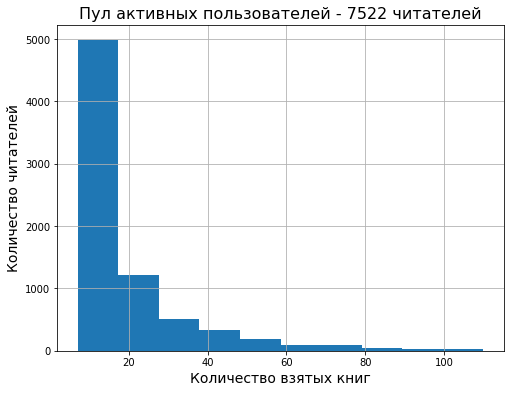

In [176]:
filter_111 = 'books_count > 6 and books_count < 111'

plt.figure(figsize=(8, 6))
user_books_count.query(filter_111).hist(ax=plt.gca())
plt.title(
    label="Пул активных пользователей - "
    + f"{user_books_count.query(filter).shape[0]} читателей", 
    size=16)
plt.xlabel("Количество взятых книг", fontsize=14)
plt.ylabel("Количество читателей", fontsize=14)
plt.show()

In [179]:
book_users_count = transactions.groupby('book_id').user_id.count().rename(columns={'chb':'users_count'})

book_users_count = (
    unique_transactions.groupby('book_id')
    .count().rename(columns={'chb':'users_count'}))


https://anchormen.nl/blog/data-science-ai/putting-a-hybrid-recommendation-system-into-production/



**Вывод**

1. Мы отобрали пользователей, которые прочитали от 6 до 111 книг (~половина)

  - попробуем обучить модель с рекомендациями на этом пуле

2. Мало книг не значит, что читатель неактивный, возможно, он только недавно пришел в библиотеку

  - пока нам это неважно, важно количество книг для качественных предсказаний

  - во время сегментации пользователей учтем этот нюанс!)

#### Обучение модели и оценка результатов


In [207]:
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()

# Делаем фильтрацию пользователей
df_ML = unique_transactions[
    unique_transactions.chb.isin(user_books_count.query(filter_111).index)
]

ValueError: ignored

In [212]:


train_data, test_data = get_train_test(df_ML)

#### Sparse матрица (user, book)

#### Общий вывод

# LightFM - Matrix Factorization (Baseline)

### Вводные

Мы протестируем работу LightFM без добавления признаков (т.е. классический подход с Matrix Factorization для Collaborative Filtering).

1. Испытаем две loss функции:

  - WARP (Weighted Approximate Rank Pairwise Loss) 
  - (BPR) Bayesian Personalized Ranking  mode

2. Попробуем разбить датасет с помощью built-in функции библиотеки LightFM.

3. Сравним итоговые результаты с ALS и посмотрим также на значения других метрик (ROC-AUC и precision@k)

Тюнингом параметров пока заниматься не будем - это baseline модель, чтобы оценить возможности нового подхода.

In [9]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 4.3 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705367 sha256=d28afe92db23d645eb28ef3d4cc3a89059b449bde88ff24135fd6b6fb6f6a6ac
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [10]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split

# Встроенные функции lightfm для метрик
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score


### Подготовка данных

In [16]:
book_actions = transactions = pd.read_csv('transactions_extended.csv', sep=';', index_col=None, dtype={'chb': str, 'date_1': str, 'is_printed': str, 'is_real': str, 'source': str, 'sys_numb': str, 'type': str})
book_actions.columns

Index(['chb', 'sys_numb', 'date_1', 'is_real', 'type', 'source', 'is_printed'], dtype='object')

In [17]:
# Создаем идентификаторы для читателей и книг
# Внутренний датасет для lightfm
light_dataset = Dataset()
light_dataset.fit(book_actions['chb'], book_actions['sys_numb'])

num_users, num_books = light_dataset.interactions_shape()
print(f'Количество читатателей: {num_users}') 
print(f'Количество книг: {num_books}')

Количество читатателей: 16753
Количество книг: 194666


- Отлично, осталось передать все данные о выдачах книг модели

- Перед этим проверим, нет ли у нас дубликатов (кто-то повторно брал книги)

In [18]:
book_actions[book_actions[['chb', 'sys_numb']].duplicated()]

,chb,sys_numb,date_1,is_real,type,source,is_printed
12,100000644359,RSL01009833577,2021-03-16,yes,книговыдача,единый просмоторщик,False
79,100000689674,RSL01003474844,2021-02-11,yes,скачивание,dlib.rsl.ru,False
115,100000689674,RSL01004840469,2021-04-06,yes,скачивание,dlib.rsl.ru,False
116,100000689674,RSL01004840469,2021-04-30,yes,скачивание,dlib.rsl.ru,False
122,100000689674,RSL01002974250,2021-03-06,yes,скачивание,dlib.rsl.ru,False
...,...,...,...,...,...,...,...
259538,300001172795,RSL01003702190,2021-03-03,yes,скачивание,dlib.rsl.ru,False
259541,300001172795,RSL01003794908,2021-02-17,yes,книговыдача,2DL.Viewer,False
259545,300001172795,RSL01003581372,2021-03-04,yes,скачивание,dlib.rsl.ru,False
259558,300001173062,RSL01002899944,2022-03-10,yes,скачка,единый просмоторщик,False


- 30 000 дубликатов! Уберем их из обучения, но позже лучше проверить, с чем это связано

In [19]:
book_user_unique = book_actions[['chb', 'sys_numb']].drop_duplicates()

In [20]:
# Добавляем в lightfm данные для рекомендаций - пары {читатель, книга}
# на входе д.б тип iterables
(interactions, weights) = light_dataset.build_interactions(
    list(zip(book_user_unique.chb, book_user_unique.sys_numb)))

print(repr(interactions))

<16753x194666 sparse matrix of type '<class 'numpy.int32'>'
	with 229002 stored elements in COOrdinate format>


- Sparse матрица (users, books) для обучения модели готовы!

In [21]:
# Проверяем, корректно ли сработал zip

# Исходный датасет
display(book_actions[['chb', 'sys_numb']].head(3))
print()

# Первые пары элементов в списке
list(zip(book_user_unique.chb, book_user_unique.sys_numb))[0:3]


,chb,sys_numb
0,100000641403,RSL01004206702
1,100000641403,RSL01000769304
2,100000641403,RSL01004211574


[('100000641403', 'RSL01004206702'),
 ('100000641403', 'RSL01000769304'),
 ('100000641403', 'RSL01004211574')]

- Все верно! Можем двигаться дальше)

### Разделение выборок (кросс-валидация)

In [22]:
# Разделяем на выборки с помощью метода lightfm
# На выходе получаем две одинаковые sparse матрицы
train_fm, test_fm = random_train_test_split(
    interactions, 
    test_percentage=0.1, 
    random_state=777)

print(f"Обучающая выборка lightfm: {train_fm.get_shape()}")
print(f"Тестовая выборка lightfm: {test_fm.get_shape()}")

Обучающая выборка lightfm: (16753, 194666)
Тестовая выборка lightfm: (16753, 194666)


Главная особенность модели lightfm:
- одинаковое количество users и items в обучающей и тестовой матрицах

### Обучаем модель

In [106]:
print("LightFM matrix factorization, loss функция = bpr")
model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train_fm, epochs=10)

train_precision = precision_at_k(model, train_fm, k=20).mean()
test_precision = precision_at_k(model, test_fm, k=20).mean()

train_auc = auc_score(model, train_fm).mean()
test_auc = auc_score(model, test_fm).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))


LightFM matrix factorization, loss функция = bpr
Precision: train 0.00, test 0.00.
AUC: train 0.57, test 0.49.


In [120]:
with open('savefile.pickle', 'wb') as fle:
    pickle.dump(model, fle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
epochs=5, num_threads=4, verbose=True 

In [11]:
# load the model from disk
model = pickle.load(open('savefile.pickle', 'rb'))

### Выгружаем результаты

In [13]:
model.get_item_representations(features=None)

array([-0.0344176 , -0.01944616,  0.01806399, ...,  0.01152962,
       -0.00060117, -0.01445462], dtype=float32)

In [27]:
light_dataset.mapping()

({'100000641403': 0,
  '100000644359': 1,
  '100000665127': 2,
  '100000676191': 3,
  '100000679200': 4,
  '100000681262': 5,
  '100000683677': 6,
  '100000689674': 7,
  '100000692449': 8,
  '100000693475': 9,
  '100000695045': 10,
  '100000697273': 11,
  '100000698405': 12,
  '100000702964': 13,
  '100000704313': 14,
  '100000705925': 15,
  '100000706981': 16,
  '100000711986': 17,
  '100000715413': 18,
  '100000717512': 19,
  '100000717612': 20,
  '100000718304': 21,
  '100000720098': 22,
  '100000722110': 23,
  '100000722645': 24,
  '100000728030': 25,
  '100000730783': 26,
  '100000733127': 27,
  '100000733883': 28,
  '100000737450': 29,
  '100000738355': 30,
  '100000738392': 31,
  '100000739467': 32,
  '100000740302': 33,
  '100000740600': 34,
  '100000742468': 35,
  '100000743169': 36,
  '100000743827': 37,
  '100000745731': 38,
  '100000747862': 39,
  '100000748443': 40,
  '100000749657': 41,
  '100000749736': 42,
  '100000752636': 43,
  '100000753646': 44,
  '100000753959': 45

## Matrix Factorization - RankFM

In [ ]:

# model = BayesianPersonalizedRanking(factors=200, verify_negative_samples=False, random_state=777)
# model.fit(full_train_sparse_data)